# NARX Modelling
ARX models have endless varieties and flavors, but not all ARX models are linear models. Nonlinear ARX, or NARX, constitutes an important generalization of our traditional ARX models while allowing us to leverage tools from machine learning to produce more sophisticated nonlinear relationships. Thus, a NARX model will have the form 
$$
y(t+1) = F\left(\tilde{y}(t), \tilde{x}_1(t),\tilde{x}_P (t) , \varepsilon(t)\right) 
$$
where $F$ is some function, tilde denotes a time-lagged vector $\tilde{y}(t):=(y(t), y(t-1), ..., y(t-Q))$ and $\varepsilon(t)$ represents a random vector that can be included to model stochastic effects.

In [1]:
# Import libraries
import numpy as np
from numpy import genfromtxt
from numpy import linalg as lin
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn import linear_model
from scipy.signal import savgol_filter
import seaborn as sns
import pandas as pd

# Import my own modules
import sys
sys.path.insert(0, '..')
from manifolds import embed

# Import data
my_data = genfromtxt('../Data/natgas.data.csv', delimiter=',',dtype='f8')
my_data = my_data[1:,1:] # Ignore the first row, which contains headers
names = ["STOCKS","HDD_FORE","CDD_FORE","JFKTEMP","CLTTEMP","ORDTEMP","HOUTEMP","LAXTEMP","NXT_CNG_STK"]

# Delete the unused features
X = my_data[0:600,:]
X = np.delete(X,1,axis=1)
X = np.delete(X,1,axis=1)
Xnames = ["STOCKS","JFKTEMP","CLTTEMP","ORDTEMP","HOUTEMP","LAXTEMP","NXT_CNG_STK"]

# Deseasonalize the data
window_length = 13
polyorder = 2
datatrend = savgol_filter(X[:,1:10], window_length, polyorder, axis=0)
#X[:,1:10] = X[:,1:10] - datatrend

# For now, take the model length as a given
Q = 3

# Delay embed all of our data. The last column will be our target
Z = np.empty((X.shape[0]-Q+1,Q*X.shape[1]))
for k in range(0,X.shape[1]):
    Z[:,np.arange(0,Q) + k*Q] = embed(X[:,k],Q,1)

# Separate target and predictors
y = Z[:,Z.shape[1]-1]  
Z = Z[:,0:Z.shape[1]-1]

# Normalize the input predictors
Z = normalize(Z, axis=0)

# Initialize matrix of predictions
NoModels = 3 # No. of models that I will have
Yp = 0*np.empty((y.shape[0],NoModels))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


## Linear Models
First, we produce some linear model predictions so that we have them for comparison. Like last time, we will consider OLS and some shrinkage estimators for the ARX(Q) models.

In [2]:
# Fit a linear model using ordinary least squares (OLS)
OLSmdl = np.linalg.lstsq(Z, y, rcond=None)
Yp[:,0] = Z @ OLSmdl[0] 

# Fit a LASSO model
LASSOmdl = linear_model.Lasso(alpha=0.1)
LASSOmdl.fit(Z, y)
Yp[:,1] = Z @ LASSOmdl.coef_

# Fit a LASSO model
ridgemdl = linear_model.Ridge(alpha=0.1)
ridgemdl.fit(Z, y)
Yp[:,2] = Z @ ridgemdl.coef_


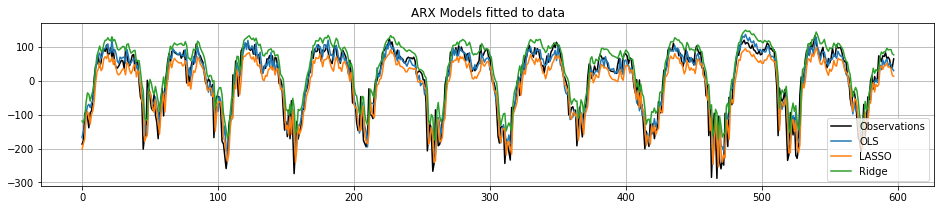

(598,)


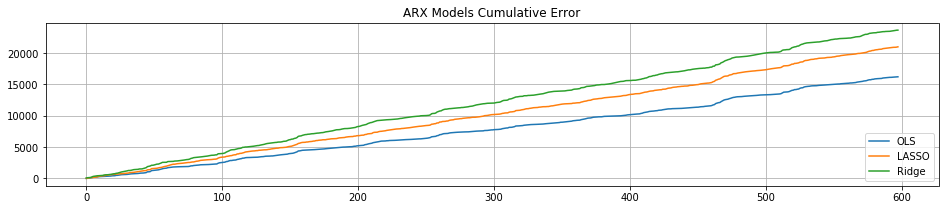

In [6]:
# Plot Predictions
t = np.transpose(np.arange(0,y.shape[0]))
plt.figure(figsize=(16, 3))
plt.plot(t,y,'k-')
plt.plot(t,Yp)
plt.legend(['Observations','OLS','LASSO','Ridge'], loc='lower right')
plt.title('ARX Models fitted to data')
plt.grid(True)
plt.show()

print(y.shape)

# Compute errors
Ype = 0*Yp
for k in range(0,Yp.shape[1]):
    Ype[:,k] = np.cumsum(np.abs(Yp[:,k]-y))    

# Plot Errors
plt.figure(figsize=(16, 3))
ax = plt.axes()
plt.plot(t,Ype)
plt.legend(['OLS','LASSO','Ridge'], loc='lower right')
plt.title('ARX Models Cumulative Error')
plt.grid(True)
plt.show()

## Neural NARX
Small feedforward net

## Gradient Boost NARX
XGBoost